<a href="https://colab.research.google.com/github/faizanahemad/eva/blob/master/assignment-14/DN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Resources**

- XLA

    - [Google Notebook example](https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/compiler/xla/g3doc/tutorials/xla_compile.ipynb)

    - [Blog](https://medium.com/@xianbao.qian/use-xla-with-keras-3ca5d0309c26)
    
- Mixed Precision

- Augmentation Libs
    - [imgaug](https://github.com/aleju/imgaug)
    - [albumentations](https://github.com/albu/albumentations)
    - [Automold](https://github.com/UjjwalSaxena/Automold--Road-Augmentation-Library)
    - [Tensorflow Examples](https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/)

# Imports

In [2]:
import numpy as np
import skimage
print(np.__version__)
print(skimage.__version__)

import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe
import gc
print(tf.__version__)
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
% matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os

import imgaug.augmenters as iaa
from matplotlib import cm
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,RandomFog,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, ChannelDropout, ChannelShuffle,RandomContrast
)

1.17.0
0.15.0
1.14.0


In [3]:
tf.enable_eager_execution()
# tf.random.set_random_seed(1234)

In [4]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.75 #@param {type:"number"}
WEIGHT_DECAY = 1e-3 #@param {type:"number"}
EPOCHS = 10 #@param {type:"integer"}
cutout_proba = 0.25
MAX_MOMENTUM = 0.9
MIN_MOMENTUM = 0.9

mixed_precision = False
xla_enabled = False

jobs = int(os.cpu_count()/2)

In [5]:
# Half Precision Checks
from tensorflow.python.client import device_lib

def check_tensor_core_gpu_present():
    local_device_protos = device_lib.list_local_devices()
    for line in local_device_protos:
        if "compute capability" in str(line):
            compute_capability = float(line.physical_device_desc.split("compute capability: ")[-1])
            if compute_capability>=7.0:
                return True

print("TensorFlow version is", tf.__version__)

try:
    # check and assert TensorFlow >= 1.14
    tf_version_list = tf.__version__.split(".")
    if int(tf_version_list[0]) < 2:
        assert int(tf_version_list[1]) >= 14
except:
    print("TensorFlow 1.14.0 or newer is required.")
    
print("Tensor Core GPU Present:", check_tensor_core_gpu_present())
assert check_tensor_core_gpu_present() == True

TensorFlow version is 1.14.0
Tensor Core GPU Present: True


In [6]:
if xla_enabled:
    config = tf.ConfigProto()
    jit_level = tf.OptimizerOptions.ON_1
    config.graph_options.optimizer_options.global_jit_level = jit_level

    sess = tf.Session(config=config)
    tf.keras.backend.set_session(sess)


In [7]:

def get_cutout_eraser(p=0.5, s_l=0.05, s_h=0.1, r_1=0.4, r_2=1 / 0.4, 
                      v_l=-1,v_h=1,
                      max_erasures_per_image=1, pixel_level=True):
    """

    :param p:
    :param s_l: Minimum Area Proportion of Original that may be cut
    :param s_h: Maximum Area Proportion of Original that may be cut
    :param r_1: Min Aspect Ratio
    :param r_2: Max Aspect Ratio
    :param max_erasures_per_image:
    :param pixel_level:
    :return: Eraser to be used as Preprocessing Function
    """
    assert max_erasures_per_image >= 1

    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        shape = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img
        mx = np.random.randint(1, max_erasures_per_image + 1)
        for i in range(mx):
            while True:
                s = np.random.uniform(s_l, s_h) * img_h * img_w
                r = np.random.uniform(r_1, r_2)
                w = int(np.sqrt(s / r))
                h = int(np.sqrt(s * r))
                left = np.random.randint(0, img_w)
                top = np.random.randint(0, img_h)

                if left + w <= img_w and top + h <= img_h:
                    break

            # print("W = ",w,"H = ",h,end =", ")

            if pixel_level:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            else:
                c = np.random.uniform(v_l, v_h)

#             input_img = tf.Variable(input_img)
#             input_img = input_img[top:top + h, left:left + w, :].assign(tf.constant(c, shape=(h, w, img_c)))
            input_img[top:top + h, left:left + w, :] = c
#         
        return input_img

    return eraser




In [8]:
log = False



def log_fn_enabled(*args):
    print(*args)
    

def log_fn_disabled(*args):
    pass

log_fn = log_fn_enabled if log else log_fn_disabled

In [9]:
#             SubPolicy(0.1, "invert", 7, 0.2, "contrast", 6, fillcolor),
#             SubPolicy(0.7, "rotate", 2, 0.3, "translateX", 9, fillcolor),
#             SubPolicy(0.8, "sharpness", 1, 0.9, "equalize", 4, fillcolor),
#             SubPolicy(0.5, "shearY", 8, 0.7, "translateY", 9, fillcolor),
#             SubPolicy(0.5, "autocontrast", 8, 0.9, "equalize", 2, fillcolor),

#             SubPolicy(0.2, "shearY", 7, 0.3, "posterize", 7, fillcolor),
#             SubPolicy(0.4, "color", 3, 0.6, "brightness", 7, fillcolor),
#             SubPolicy(0.3, "sharpness", 9, 0.7, "brightness", 9, fillcolor),
#             SubPolicy(0.8, "equalize", 5, 0.5, "translateX", 4, fillcolor),
#             SubPolicy(0.6, "contrast", 7, 0.6, "sharpness", 5, fillcolor),

#             SubPolicy(0.7, "color", 7, 0.5, "translateX", 8, fillcolor),
#             SubPolicy(0.3, "equalize", 7, 0.4, "autocontrast", 8, fillcolor),
#             SubPolicy(0.4, "translateY", 3, 0.2, "sharpness", 6, fillcolor),
#             SubPolicy(0.9, "brightness", 6, 0.2, "color", 8, fillcolor),
#             SubPolicy(0.5, "solarize", 2, 0.0, "invert", 3, fillcolor),

#             SubPolicy(0.2, "equalize", 0, 0.6, "autocontrast", 0, fillcolor),
#             SubPolicy(0.2, "equalize", 8, 0.8, "sharpness", 3, fillcolor),
#             SubPolicy(0.9, "color", 9, 0.6, "equalize", 6, fillcolor),
#             SubPolicy(0.8, "autocontrast", 4, 0.2, "solarize", 8, fillcolor),
#             SubPolicy(0.1, "brightness", 3, 0.7, "color", 0, fillcolor),

#             SubPolicy(0.4, "solarize", 5, 0.9, "autocontrast", 3, fillcolor),
#             SubPolicy(0.9, "translateX", 9, 0.7, "translateY", 9, fillcolor),
#             SubPolicy(0.9, "autocontrast", 2, 0.8, "solarize", 3, fillcolor),
#             SubPolicy(0.8, "equalize", 8, 0.1, "invert", 3, fillcolor),
#             SubPolicy(0.7, "translateY", 9, 0.9, "autocontrast", 1, fillcolor)

In [18]:
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import random

class CIFAR10Policy(object):
    """ Randomly choose one of the best 25 Sub-policies on CIFAR10.
        Example:
        >>> policy = CIFAR10Policy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     CIFAR10Policy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128), log=False):
        self.policies = [
            SubPolicy(0.1, "invert", 7, 0.2, "contrast", 6, fillcolor),
            SubPolicy(0.7, "rotate", 2, 0.3, "translateX", 9, fillcolor),
            SubPolicy(0.8, "sharpness", 1, 0.9, "sharpness", 3, fillcolor),
            SubPolicy(0.5, "shearY", 8, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.5, "autocontrast", 8, 0.9, "equalize", 2, fillcolor),

            SubPolicy(0.2, "shearY", 7, 0.3, "posterize", 7, fillcolor),
            SubPolicy(0.4, "color", 3, 0.6, "brightness", 7, fillcolor),
            SubPolicy(0.3, "sharpness", 9, 0.7, "brightness", 9, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.5, "equalize", 1, fillcolor),
            SubPolicy(0.6, "contrast", 7, 0.6, "sharpness", 5, fillcolor),

            SubPolicy(0.7, "color", 7, 0.5, "translateX", 8, fillcolor),
            SubPolicy(0.3, "equalize", 7, 0.4, "autocontrast", 8, fillcolor),
            SubPolicy(0.4, "translateY", 3, 0.2, "sharpness", 6, fillcolor),
            SubPolicy(0.9, "brightness", 6, 0.2, "color", 8, fillcolor),
            SubPolicy(0.5, "solarize", 2, 0.0, "invert", 3, fillcolor),

            SubPolicy(0.2, "equalize", 0, 0.6, "autocontrast", 0, fillcolor),
            SubPolicy(0.2, "equalize", 8, 0.8, "equalize", 4, fillcolor),
            SubPolicy(0.9, "color", 9, 0.6, "equalize", 6, fillcolor),
            SubPolicy(0.8, "autocontrast", 4, 0.2, "solarize", 8, fillcolor),
            SubPolicy(0.1, "brightness", 3, 0.7, "color", 0, fillcolor),

            SubPolicy(0.4, "solarize", 5, 0.9, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "translateY", 9, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.9, "autocontrast", 2, 0.8, "solarize", 3, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.1, "invert", 3, fillcolor),
            SubPolicy(0.7, "translateY", 9, 0.9, "autocontrast", 1, fillcolor)
        ]
        self.log = log


    def __call__(self, img, policy_idx=None):
        policy_idx = random.randint(0, len(self.policies) - 1) if policy_idx is None else policy_idx
        log_fn("Policy = ",policy_idx)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment CIFAR10 Policy"

    

class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        ranges = {
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(np.int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }

        # from https://stackoverflow.com/questions/5252170/specify-image-filling-color-when-rotating-in-python-with-pil-and-setting-expand
        def rotate_with_fill(img, magnitude):
            rot = img.convert("RGBA").rotate(magnitude)
            return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(img.mode)

        func = {
            "shearX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "shearY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "translateX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, magnitude * img.size[0] * random.choice([-1, 1]), 0, 1, 0),
                fillcolor=fillcolor),
            "translateY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * img.size[1] * random.choice([-1, 1])),
                fillcolor=fillcolor),
            "rotate": lambda img, magnitude: rotate_with_fill(img, magnitude),
            # "rotate": lambda img, magnitude: img.rotate(magnitude * random.choice([-1, 1])),
            "color": lambda img, magnitude: ImageEnhance.Color(img).enhance(1 + magnitude * random.choice([-1, 1])),
            "posterize": lambda img, magnitude: ImageOps.posterize(img, magnitude),
            "solarize": lambda img, magnitude: ImageOps.solarize(img, magnitude),
            "contrast": lambda img, magnitude: ImageEnhance.Contrast(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "sharpness": lambda img, magnitude: ImageEnhance.Sharpness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "brightness": lambda img, magnitude: ImageEnhance.Brightness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "autocontrast": lambda img, magnitude: ImageOps.autocontrast(img),
            "equalize": lambda img, magnitude: ImageOps.equalize(img),
            "invert": lambda img, magnitude: ImageOps.invert(img)
        }

        # self.name = "{}_{:.2f}_and_{}_{:.2f}".format(
        #     operation1, ranges[operation1][magnitude_idx1],
        #     operation2, ranges[operation2][magnitude_idx2])
        self.p1 = p1
        self.operation1 = func[operation1]
        self.op1_name = operation1
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.p2 = p2
        self.operation2 = func[operation2]
        self.op2_name = operation2
        self.magnitude2 = ranges[operation2][magnitude_idx2]


    def __call__(self, img):
        r1 = random.random()
        r2 = random.random()
        log_fn("r1=%.3f"%r1,"p1=%.3f"%self.p1,self.op1_name,"Mag=%.3f"%self.magnitude1)
        log_fn("r2=%.3f"%r2,"p2=%.3f"%self.p2,self.op2_name,"Mag=%.3f"%self.magnitude2)
        if r1 < self.p1: img = self.operation1(img, self.magnitude1)
        if r2 < self.p2: img = self.operation2(img, self.magnitude2)
        return img


# Network Functions

In [19]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
    fan = np.prod(shape[:-1])
    bound = 1 / math.sqrt(fan)
    return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [20]:
class ConvBN(tf.keras.Model):
    def __init__(self, c_out, kernel_size=3, bn=False, strides=1):
        super().__init__()
        self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=kernel_size,strides=strides, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
        self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

    def call(self, inputs):
        res = tf.nn.relu(self.bn(self.conv(inputs)))
#         res = tf.nn.relu(self.conv(inputs))
        return res

In [21]:
class ResBlk(tf.keras.Model):
    def __init__(self, c_out, pool, res = False):
        super().__init__()
        self.conv_bn = ConvBN(c_out)
        self.pool = pool
        self.res = res
        if self.res:
            self.res1 = ConvBN(c_out)
            self.res2 = ConvBN(c_out)

    def call(self, inputs):
        h = self.pool(self.conv_bn(inputs))
        if self.res:
            h = h + self.res2(self.res1(h))
        return h
    
    
class ResBlkThin(tf.keras.Model):
    def __init__(self, c_out, pool, res = False):
        super().__init__()
        self.conv_bn = ConvBN(c_out)
        self.pool = pool
        self.res = res
        if self.res:
            self.res1 = ConvBN(int(c_out/2))
            self.res2 = ConvBN(c_out)

    def call(self, inputs):
        h = self.pool(self.conv_bn(inputs))
        if self.res:
            h = h + self.res2(self.res1(h))
        return h
    


In [22]:
class DavidNet(tf.keras.Model):
    def __init__(self, c=64, weight=0.125):
        super().__init__()
        pool = tf.keras.layers.MaxPooling2D()
        self.init_conv_bn = ConvBN(c,kernel_size=3)
        self.blk1 = ResBlk(c*2, pool, res = True)
        self.blk2 = ResBlk(c*4, pool)
        self.blk3 = ResBlk(c*8, pool, res = True)
        self.pool = tf.keras.layers.GlobalMaxPool2D()
        self.hidden = tf.keras.layers.Dense(64, kernel_initializer=init_pytorch, use_bias=False, activation='relu')
        self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
        self.weight = weight
#         self.bn1 = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
#         self.bn2 = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

    def call(self, x, y):
        h = self.init_conv_bn(x)
        h = self.blk1(h)
#         h = self.bn1(h)
        h = self.blk2(h)
#         h = self.bn1(h)
        h = self.blk3(h)
#         h = self.bn2(h)
        h = self.pool(h)
#         h = self.hidden(h)
        h = self.linear(h) * self.weight
        ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
        loss = tf.reduce_sum(ce)
        correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
        return loss, correct

In [23]:
class DavidNet2(tf.keras.Model):
    def __init__(self, c=64, weight=0.125):
        super().__init__()
        pool = tf.keras.layers.MaxPooling2D()
        self.init_conv_bn = ConvBN(c,kernel_size=3)
        self.blk1 = ResBlk(c*2, pool, res = True)
        self.blk2 = ConvBN(c*4,kernel_size=3)
        self.blk3 = ResBlk(c*8, pool, res = True)
        self.pool = tf.keras.layers.GlobalMaxPool2D()
        self.hidden = tf.keras.layers.Dense(64, kernel_initializer=init_pytorch, use_bias=False, activation='relu')
        self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
        self.weight = weight
#         self.bn1 = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
#         self.bn2 = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

    def call(self, x, y):
        h = self.init_conv_bn(x)
        h = self.blk1(h)
#         h = self.bn1(h)
        h = self.blk2(h)
#         h = self.bn1(h)
        h = self.blk3(h)
#         h = self.bn2(h)
        h = self.pool(h)
#         h = self.hidden(h)
        h = self.linear(h) * self.weight
        ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
        loss = tf.reduce_sum(ce)
        correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
        return loss, correct

In [24]:

class ResBlk2(tf.keras.Model):
    def __init__(self, c_in, c_out, pool, pooling = True):
        super().__init__()
        c = c_out if pooling else c_out - c_in
        self.conv_bn = ConvBN(c, kernel_size=1, strides=2 if pooling else 1)
        self.pool = pool
        
        self.res1 = ConvBN(c_out)
        self.res2 = ConvBN(c_out)
        self.pooling = pooling

    def call(self, inputs):
        h = self.res2(self.res1(inputs))
        in_temp = inputs
        inputs = self.conv_bn(inputs)
        if self.pooling:
            h = self.pool(h)
        else:
            inputs = tf.keras.layers.concatenate([inputs,in_temp])
        h = h + inputs
        return h

In [25]:
class DavidNet3(tf.keras.Model):
    def __init__(self, c=64, weight=0.125):
        super().__init__()
        pool = tf.keras.layers.MaxPooling2D()
        self.init_conv_bn = ConvBN(c,kernel_size=3)
        self.blk1 = ResBlk(c*2, pool, res = True)
        self.blk2 = ResBlk(c*4, pool)
        self.btl = ConvBN(int(c*1.5), kernel_size=1)
        self.blk3 = ResBlk(c*8, pool, res = True)
        self.pool = tf.keras.layers.GlobalMaxPool2D()
        self.hidden = tf.keras.layers.Dense(64, kernel_initializer=init_pytorch, use_bias=False, activation='relu')
        self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
        self.weight = weight
#         self.bn1 = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
#         self.bn2 = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

    def call(self, x, y):
        h = self.init_conv_bn(x)
        h = self.blk1(h)
#         h = self.bn1(h)
        h = self.blk2(h)
        h = self.btl(h)
#         h = self.bn1(h)
        h = self.blk3(h)
#         h = self.bn2(h)
        h = self.pool(h)
#         h = self.hidden(h)
        h = self.linear(h) * self.weight
        ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
        loss = tf.reduce_sum(ce)
        correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
        return loss, correct

In [26]:
class DavidNet4(tf.keras.Model):
    def __init__(self, c=64, weight=0.125):
        super().__init__()
        pool = tf.keras.layers.MaxPooling2D()
        self.init_conv_bn = ConvBN(c,kernel_size=3)
        self.blk1 = ResBlk(c*2, pool, res = True)
        self.blk2 = ConvBN(c*4, kernel_size=3)
        self.btl = ConvBN(int(c*1.5), kernel_size=1)
        self.blk3 = ResBlk2(int(c*1.5),c*4, pool, pooling = True)
        self.blk4 = ResBlk2(c*4,c*8, pool, pooling = False)
        self.pool = tf.keras.layers.GlobalMaxPool2D()
        self.hidden = tf.keras.layers.Dense(64, kernel_initializer=init_pytorch, use_bias=False, activation='relu')
        self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
        self.weight = weight
#         self.bn1 = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
#         self.bn2 = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

    def call(self, x, y):
        h = self.init_conv_bn(x)
        h = self.blk1(h)
#         h = self.bn1(h)
        h = self.blk2(h)
        h = self.btl(h)
#         h = self.bn1(h)
        h = self.blk3(h)
        h = self.blk4(h)
#         h = self.bn2(h)
        h = self.pool(h)
#         h = self.hidden(h)
        h = self.linear(h) * self.weight
        ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
        loss = tf.reduce_sum(ce)
        correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
        return loss, correct

# Data Preparation

In [27]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='median')

# x_train = normalize(pad4(x_train))
x_test = normalize(x_test)

In [28]:
print(gc.collect())

model = DavidNet3(weight=0.125)
batches_per_epoch = len_train//BATCH_SIZE + 1

# lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//3, EPOCHS], [0, LEARNING_RATE, 0])[0]

# lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//3, EPOCHS-1, EPOCHS], [LEARNING_RATE/20, LEARNING_RATE, LEARNING_RATE/10, LEARNING_RATE/40])[0]

# lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//3,(EPOCHS+1)//3 + 1, EPOCHS-1, EPOCHS], [LEARNING_RATE/20, LEARNING_RATE,LEARNING_RATE, LEARNING_RATE/10, LEARNING_RATE/40])[0] # LR = 1
# lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//2.5,(EPOCHS+1)//2.5 + 1, EPOCHS-1, EPOCHS], [LEARNING_RATE/20, LEARNING_RATE,LEARNING_RATE, LEARNING_RATE/10, LEARNING_RATE/40])[0] # LR = 1

# lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//3,(EPOCHS+1)//3 + 1, EPOCHS-1, EPOCHS], [0.1, LEARNING_RATE,LEARNING_RATE/4, 0.1, 0.05])[0] # LR = 1

# lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//2.5,(EPOCHS+1)//2.5 + 1, EPOCHS-1, EPOCHS], [LEARNING_RATE/40, LEARNING_RATE,LEARNING_RATE, LEARNING_RATE/20, LEARNING_RATE/50])[0]

lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//2.5,(EPOCHS+1)//2.5 + 1, EPOCHS-1, EPOCHS], [LEARNING_RATE/10, LEARNING_RATE,LEARNING_RATE, LEARNING_RATE/10, LEARNING_RATE/20])[0] # LR = 0.75

# momentum_schedule =  lambda t: np.interp([t], [0, (EPOCHS+1)//2.5,(EPOCHS+1)//2.5 + 1, EPOCHS], [MAX_MOMENTUM, MIN_MOMENTUM,MIN_MOMENTUM, MAX_MOMENTUM])[0] 
momentum_schedule =  lambda t: np.interp([t], [0, EPOCHS], [MAX_MOMENTUM, MIN_MOMENTUM])[0] 

global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
momentum_func = lambda: momentum_schedule(global_step/batches_per_epoch)/BATCH_SIZE
# opt = tf.train.MomentumOptimizer(lr_func, momentum=momentum_func, use_nesterov=True)
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)

if mixed_precision:
    opt = tf.train.experimental.enable_mixed_precision_graph_rewrite(opt)

hflip_aug = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)
hue_aug = lambda x,y: (tf.image.random_hue(x,max_delta=0.1),y)

brightness_aug = lambda x,y: (tf.image.random_brightness(x,max_delta=0.1),y) # Not useful
contrast_aug = lambda x, y: (tf.image.random_contrast(x,0.7, 1.3), y)

saturation_aug = lambda x, y: (tf.image.random_saturation(x, 0.7, 1.3), y)
jpeg_aug = lambda x, y: (tf.image.random_jpeg_quality(x, 80, 100), y)

# data_aug = lambda x, y:hue_aug(*hflip_aug(*saturation_aug(x,y)))
data_aug1 = lambda x, y:hue_aug(*hflip_aug(x,y))

data_aug2 = lambda x, y:saturation_aug(*contrast_aug(*brightness_aug(x,y)))

data_aug = lambda x, y: data_aug2(*data_aug1(x,y))

# rot90 = lambda x,y: (tf.image.rot90(x, np.random.choice([0,1,3],p=[1-rot90_proba,rot90_proba/2,rot90_proba/2])),y)

cutout_fn = get_cutout_eraser(p=1.0, pixel_level=True)

def batch_cut(imgs, epoch,cutout_proba=cutout_proba,copy=False):
    if copy:
        imgs = np.copy(imgs)
    for i,im in enumerate(imgs):
        p_1 = np.random.rand()
        if p_1 > cutout_proba:
            continue
        else:
            imgs[i] = cutout_fn(im)
    return imgs

def cifar10_augs(imgs,epoch):
    policy = CIFAR10Policy()
    for i,im in enumerate(imgs):
        im = Image.fromarray(np.uint8(im),'RGB')
        im = policy(im)
        imgs[i] = np.array(im)
    return imgs


88


<Figure size 144x144 with 0 Axes>

Text(0.5, 1.0, 'bird')

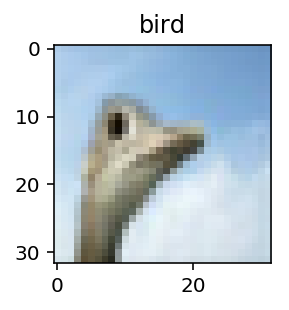

W0816 21:29:42.996525 140266619397952 deprecation.py:323] From <ipython-input-29-06e2385d875d>:17: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


222 21


<Figure size 144x144 with 0 Axes>

Text(0.5, 1.0, 'bird')

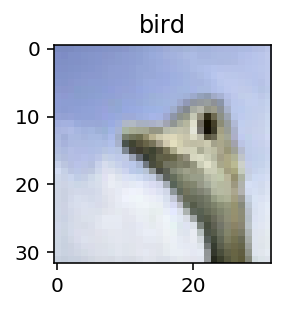

In [29]:
exampleId = np.random.randint(0,len_train)
example = x_train[exampleId]


plt.figure(figsize=(2,2))
plt.title(classes[y_train[exampleId]])
ex = (example - np.min(example))/(np.max(example)-np.min(example))
plt.imshow(ex)
plt.show()


example = cifar10_augs(np.array([example]),14)


ts = tf.data.Dataset.from_tensor_slices((example, np.array([y_train[exampleId]]))).map(data_aug, num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(1)
# ts = tf.data.Dataset.from_tensor_slices((example, np.array([y_train[exampleId]]))).prefetch(1)
x,y = next(ts.make_one_shot_iterator())
x,y = x.numpy(),y.numpy()
example=x
print(np.max(example),np.min(example))
ex = (example - np.min(example))/(np.max(example)-np.min(example))
plt.figure(figsize=(2,2))
plt.title(classes[y_train[exampleId]])
plt.imshow(ex)
plt.show()

# Augmentation

In [21]:
print(gc.collect())
train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))
normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here   
t1 = time.time()
train_data = {}
for epoch in range(EPOCHS):
    cp = 0
    
    xt = np.copy(x_train)
    cp = np.interp([epoch], [0,4,5,9], [0.0,0.0, 0.2, 0.3], )[0]
    xt = batch_cut(xt, epoch, cutout_proba=cp, copy=False)
    xt = cifar10_augs(xt,epoch)
    xt = normalize(xt)
    
    train_set = tf.data.Dataset.from_tensor_slices((xt, y_train)).map(data_aug1, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(len_train).batch(len_train).prefetch(len_train)

    i = 0
    for x,y in train_set:
        assert x.numpy().shape[0]==len_train
        train_set = (x.numpy(),y.numpy())
        i = i+1
    assert i==1
    train_data[epoch] = train_set
    
    
    if epoch%2==1:
        print("Epoch = ",epoch," Time = ",(time.time()-t1), "CP = %.2f"%(cp))
t2 = time.time()
"%.1f" %(t2-t1)


1801
Epoch =  1  Time =  42.203235149383545 CP = 0.00
Epoch =  3  Time =  84.22359895706177 CP = 0.00
Epoch =  5  Time =  127.45511388778687 CP = 0.20
Epoch =  7  Time =  171.2668285369873 CP = 0.25
Epoch =  9  Time =  215.44281673431396 CP = 0.30


'215.4'

# Persist/Read Train Set

## Persist

In [26]:
import dill as pickle
with open('train_data_s2.pkl', 'wb') as file:
    pickle.dump(train_data, file)

## Read 

In [30]:
import dill as pickle
with open('train_data_s2.pkl', 'rb') as file:
    train_data = pickle.load(file)

# Model Running / Training Loop

In [31]:
print(gc.collect())
t = time.time()
t_last = time.time()
train_accs = []
test_accs = []
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(1)

for epoch in range(EPOCHS):
    train_loss = test_loss = train_acc = test_acc = 0.0
    train_set = train_data[epoch]
    train_set = tf.data.Dataset.from_tensor_slices(train_set).batch(BATCH_SIZE).prefetch(1)
    tf.keras.backend.set_learning_phase(1)
    for (x, y) in train_set:
        with tf.GradientTape() as tape:
            loss, correct = model(x, y)

        var = model.trainable_variables
        grads = tape.gradient(loss, var)
        for g, v in zip(grads, var):
            g += v * (WEIGHT_DECAY/(epoch+1)) * BATCH_SIZE
        opt.apply_gradients(zip(grads, var), global_step=global_step)

        train_loss += loss.numpy()
        train_acc += correct.numpy()

    tf.keras.backend.set_learning_phase(0)
    for (x, y) in test_set:
        loss, correct = model(x, y)
        test_loss += loss.numpy()
        test_acc += correct.numpy()

    t2 = time.time()
    epoch_time = t2 - t_last
    t_last = t2
    train_accs.append(train_acc / len_train)
    test_accs.append(test_acc / len_test)
    print("epoch = %2s"%epoch,'lr: %.2f' % (lr_schedule(epoch+1)),"Mo: %.2f"%(momentum_schedule(epoch+1)), '||train=> loss: %.3f' %(train_loss / len_train), 'acc: %.3f' % (train_acc / len_train), '||val=> loss: %.3f' % (test_loss / len_test), 'val acc: %.3f' %(test_acc / len_test),"%.1fs"%(epoch_time), '%.1fs'%(t2 - t))
    
    



# epoch =  9 lr: 0.04 Mo: 0.90 ||train=> loss: 0.328 acc: 0.888 ||val=> loss: 0.287 val acc: 0.903 15.1s 157.0s

1794
epoch =  0 lr: 0.24 Mo: 0.90 ||train=> loss: 1.631 acc: 0.408 ||val=> loss: 1.229 val acc: 0.580 21.3s 21.3s
epoch =  1 lr: 0.41 Mo: 0.90 ||train=> loss: 1.110 acc: 0.616 ||val=> loss: 0.888 val acc: 0.692 15.8s 37.0s
epoch =  2 lr: 0.58 Mo: 0.90 ||train=> loss: 0.897 acc: 0.692 ||val=> loss: 0.711 val acc: 0.760 16.0s 53.0s
epoch =  3 lr: 0.75 Mo: 0.90 ||train=> loss: 0.758 acc: 0.738 ||val=> loss: 0.637 val acc: 0.780 16.0s 69.0s
epoch =  4 lr: 0.75 Mo: 0.90 ||train=> loss: 0.652 acc: 0.774 ||val=> loss: 0.464 val acc: 0.839 16.0s 85.0s
epoch =  5 lr: 0.58 Mo: 0.90 ||train=> loss: 0.574 acc: 0.800 ||val=> loss: 0.528 val acc: 0.833 16.0s 100.9s
epoch =  6 lr: 0.41 Mo: 0.90 ||train=> loss: 0.496 acc: 0.828 ||val=> loss: 0.458 val acc: 0.847 16.1s 117.0s
epoch =  7 lr: 0.24 Mo: 0.90 ||train=> loss: 0.432 acc: 0.849 ||val=> loss: 0.359 val acc: 0.879 16.0s 133.0s
epoch =  8 lr: 0.07 Mo: 0.90 ||train=> loss: 0.374 acc: 0.871 ||val=> loss: 0.303 val acc: 0.895 16.0s 149.1s
epoch =  9

In [23]:
def make_plots():
    plt.figure(figsize=(12,4))
    plt.title("Train acc = %.3f, Test acc = %.3f"%(train_accs[-1],test_accs[-1]))
    plt.plot(train_accs)
    plt.plot(test_accs)
    plt.show()


    plt.figure(figsize=(12,4))
    plt.title("Train acc = %.3f, Test acc = %.3f"%(train_accs[-1],test_accs[-1]))
    plt.plot(list(range(3,len(train_accs))),train_accs[3:])
    plt.plot(list(range(3,len(test_accs))),test_accs[3:])
    plt.show()
    return

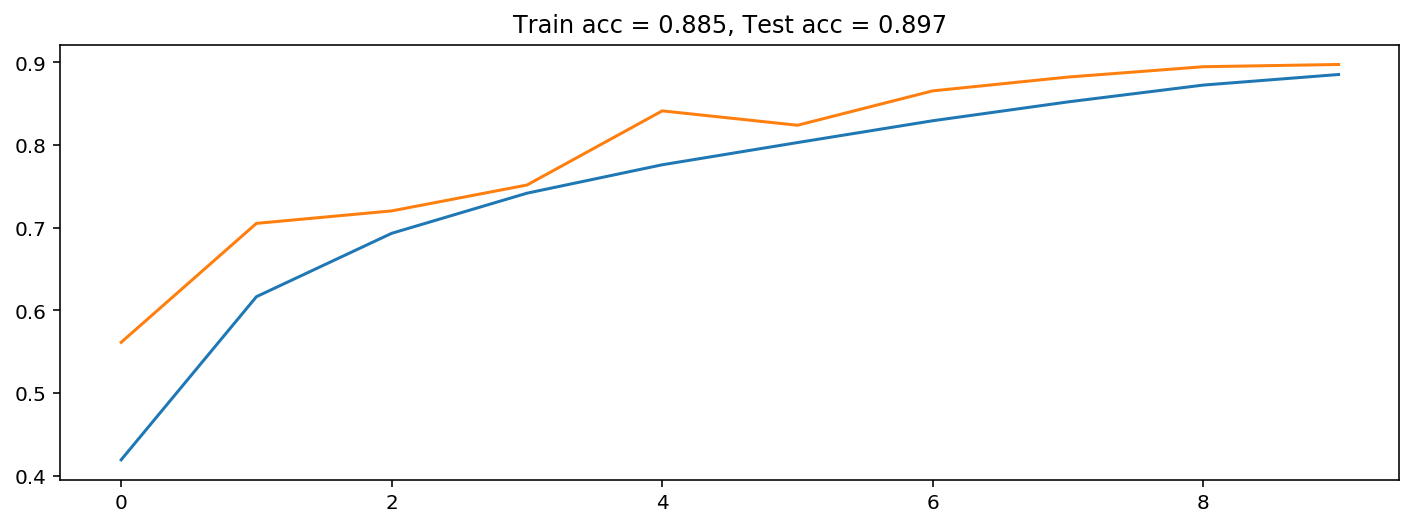

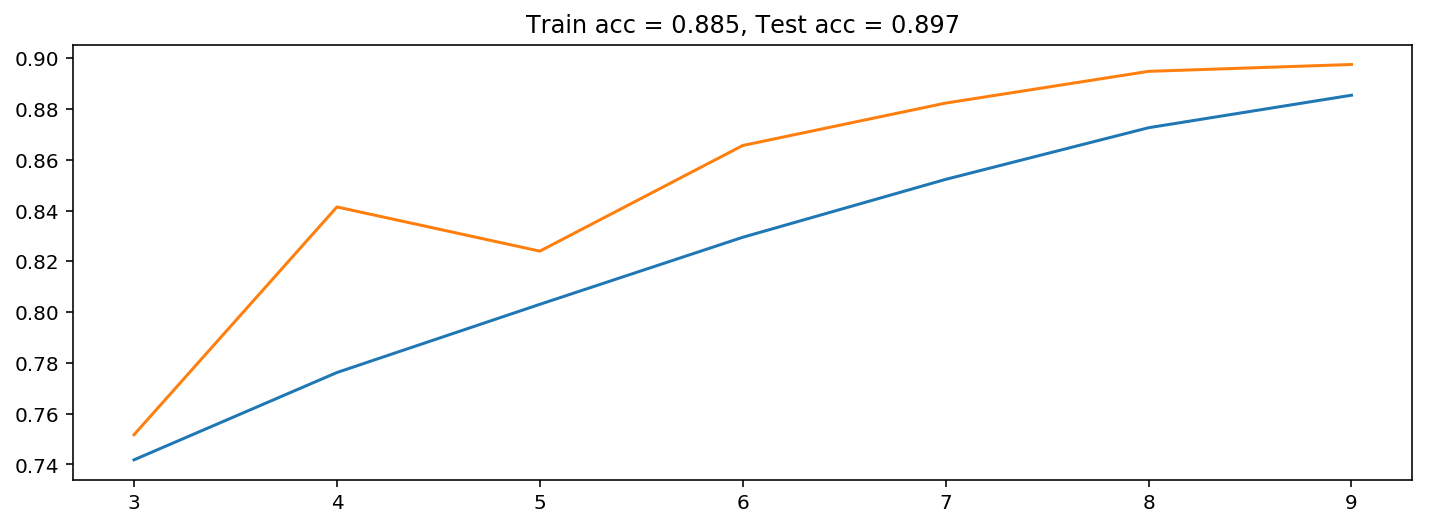

In [24]:
make_plots()

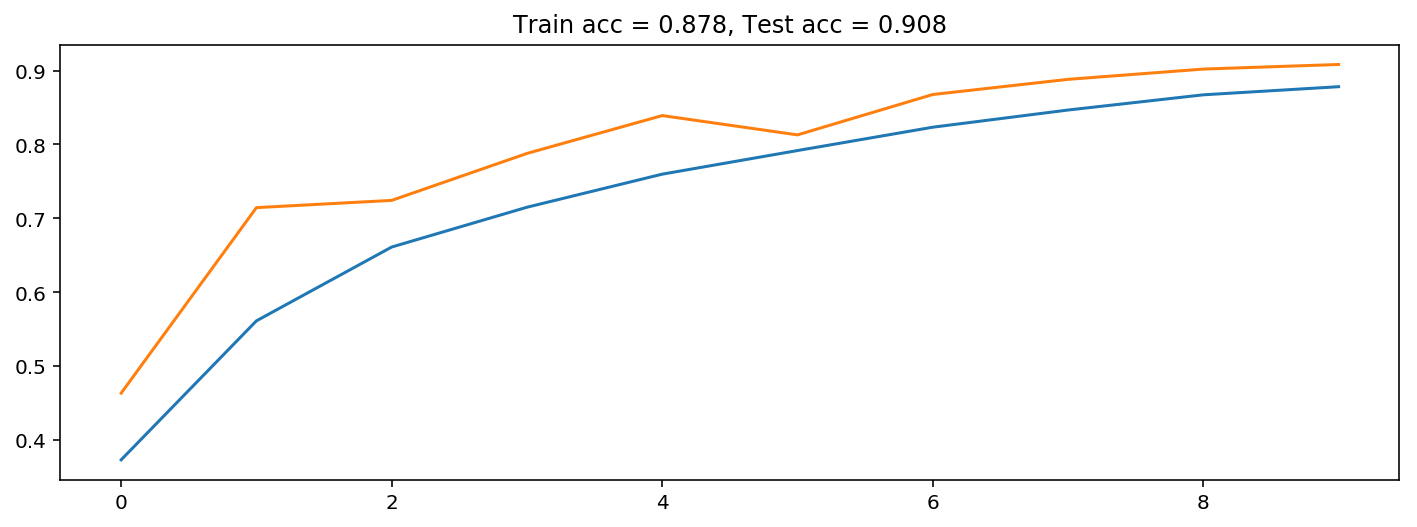

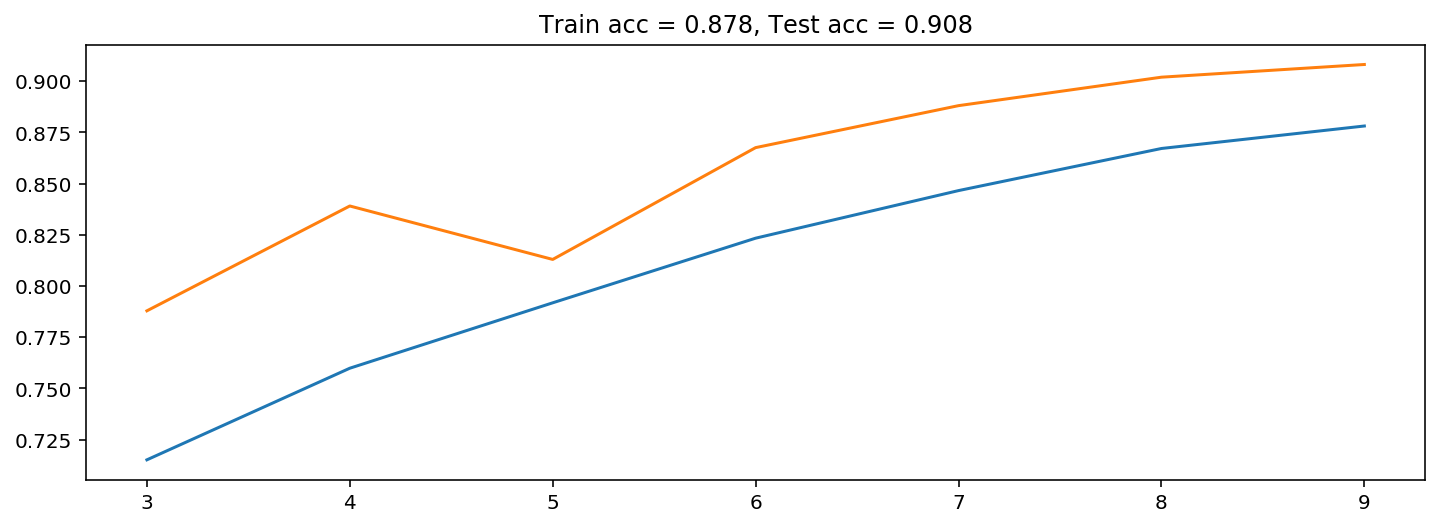

In [26]:
make_plots()